In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import pairwise_distances, segpath2path, point2segments

In [2]:
# record_dir = 'sensor_learn_robustness_3in1_randomroute'  # sensor noise in vision and vector 
# record_dir = 'sensor_noisefreetrain_robustness_3in1_randomroute'  # no sensor noise in learning
# record_dir = 'sensory_robustness_3in1_randomroute'  # only visual noise but no vector noise in learning # nice result

# record_dir = 'noise_noisefreetrain_robustness_3in1_randomroute'
# record_dir = 'noise_noisefreetrain_robustness_3in1_randomroute_noobj'

# record_dir = 'motor_learn_robustness_3in1_randomroute'  # noise in vector memory too
record_dir = 'motor_robustness_3in1_randomroute'  # no noise in vector memory
# record_dir = 'motor_robustness_3in1_randinitorn_nosignofrandinitorn'

# 'motor_robustness_3in1_randomexplore': training route is randomly generated by random walk, not shortest path
var_name = 'noise_motor'   # 'noise' # 'noise_sensor'#   
ls_value = 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, #20, 50
n_condition = len(ls_value)
catchment_radius = 0# 0.372 / 2 ## 0.372 is the wheel axle length of Freight

In [3]:
n_trial = 100
n_epoch_train, n_epoch_test = 120, 500
goal_idx = -1  # does not change too much
ls_model = 'pure-pursuit', 'lamb', 'visual-localisor'
ls_model_keys = ls_model
ls_model_name = 'pure-pursuit', 'differential-MB', 'visual-localisor'
ls_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# retrieve data

In [4]:
data_path = {}
for model_name in ls_model_name:
    data_path[model_name] = {'train': [], 'train_c': [], 'train_p': [],
                             'test': [], 'test_c': [], 'test_p': []}

for val in ls_value:
    data_dir = os.path.join('records', record_dir, '{}{}'.format(var_name, val))
    for trial_idx, trial_dir in enumerate(sorted(os.listdir(data_dir))[:n_trial]):
        path = {'test': None, 'train': None}
        ### load path data
        for model_key, model_name in zip(ls_model_keys, ls_model_name):
            for phase in ('train', 'test'):
                file_idx = '' if phase == 'train' else '{}_'.format(model_key)
                data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_{}record.npz'.format(phase, file_idx))
                try:
                    data_load = np.load(data_file, allow_pickle=True)
                    path = np.array([data_load[arg] for arg in 'xy'])
                    path_cp = [data_load['extra'][()][key] for key in ('collision', 'proximity')]
                except:
                    print("The file {} does not exist.".format(data_file))
                data_path[model_name][phase].append(path)
                for cp, cp_data in zip('cp', path_cp):
                    phase_cp = '{}_{}'.format(phase, cp)
                    data_path[model_name][phase_cp].append(cp_data)
    
for model_name in ls_model_name:
    for phase, n_epoch in zip(('train', 'test'), (n_epoch_train, n_epoch_test)):
        data_path[model_name][phase] = np.reshape(data_path[model_name][phase], (n_condition, n_trial, 2, n_epoch))
        for cp in 'cp':
            phase_cp = '{}_{}'.format(phase, cp)
            data_path[model_name][phase_cp] = np.reshape(data_path[model_name][phase_cp], (n_condition, n_trial, n_epoch))
        
# np.save(os.path.join('records', record_dir, 'data_path.npy'), data_path)

In [5]:
# data_path = np.load(os.path.join('records', record_dir, 'data_path.npy'), allow_pickle=True)[()]

# minimal distance to goal and time reaching it

In [6]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}

for model_name in ls_model_name:
    path_train_init = data_path[model_name]['train'][:, :, :, 0]
    path_train_goal = data_path[model_name]['train'][:, :, :, -1]
    dist_init2goal = np.linalg.norm(path_train_goal - path_train_init, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'], axis=2)
    time_min_dist2goal = np.argmin(dist_test2goal, axis=2)
    min_dist2goal = np.min(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)

In [7]:
data_dist_test2path, data_dist_test2line = {}, {}

for model_name in ls_model_name:
    model_dist_test2path, model_dist_test2line = [], []
    for path_train_val, path_test_val in zip(data_path[model_name]['train'], data_path[model_name]['test']):
        val_dist_test2path, val_dist_test2line = [], []
        for path_train_trial, path_test_trial in zip(path_train_val, path_test_val):
            dist_test2path = [point2segments(xy, path_train_trial.T) for xy in path_test_trial.T]
            val_dist_test2path.append(dist_test2path)
#             dist_test2line = [point2segments(xy, path_train_trial.T[[0, -1]]) for xy in path_test_trial.T]
#             val_dist_test2line.append(dist_test2line)
#         model_dist_test2line.append(val_dist_test2line)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dist_test2path[model_name] = np.array(model_dist_test2path)
#     data_dist_test2line[model_name] = np.array(model_dist_test2line)

<ipython-input-8-f6feb799b6c9>:34: RuntimeWarning: Mean of empty slice
  cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-8-f6feb799b6c9>:34: RuntimeWarning: Mean of empty slice
  cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/

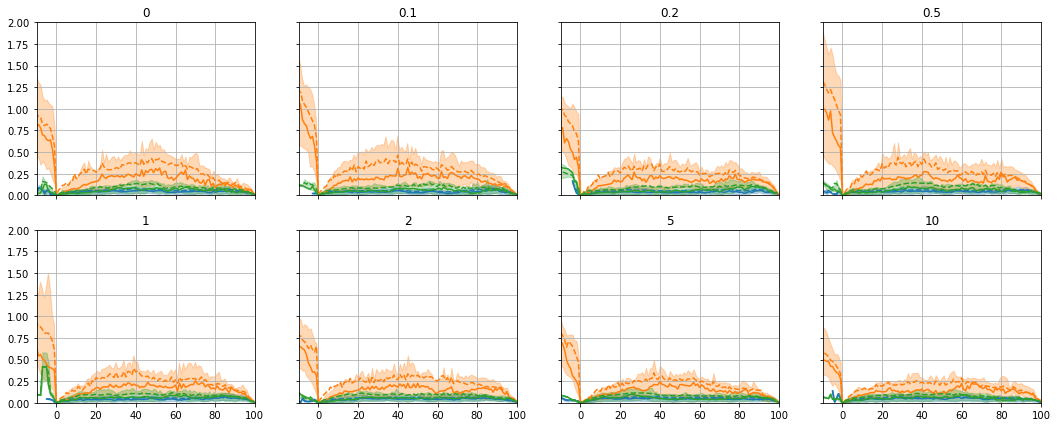

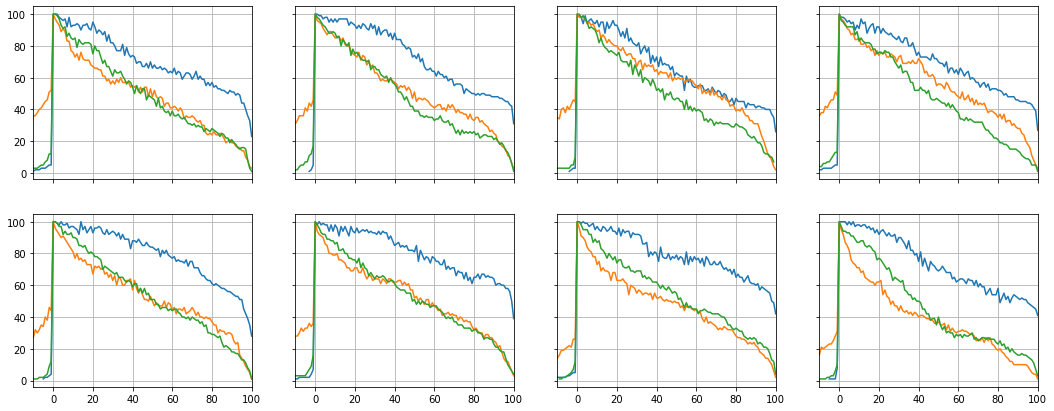

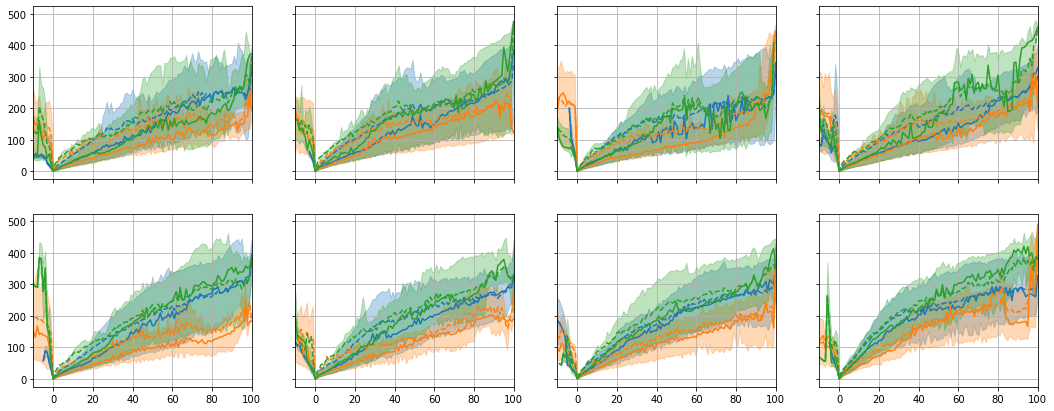

In [8]:
fig, axes = plt.subplots(2, n_condition // 2, figsize=(18, 7), sharey=True, sharex=True)
fig, bxes = plt.subplots(2, n_condition // 2, figsize=(18, 7), sharey=True, sharex=True)
fig, cxes = plt.subplots(2, n_condition // 2, figsize=(18, 7), sharey=True, sharex=True)


for model_name, color in zip(ls_model_name, ls_color):
    for ax, bx, cx, val, dist_test2goal, dist_test2path in zip(axes.flatten(), bxes.flatten(), cxes.flatten(), ls_value, 
                                                           data_dist_test2goal[model_name], 
                                                           data_dist_test2path[model_name]):
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
        progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

        val_test2path, val_n_point = [], []
        val_ptime = []
        for trial_progress, trial_test2path in zip(progress, dist_test2path):
            px, pxidx = np.unique(trial_progress, return_index=True)
            t2p_interp = np.interp(progress_step, px, trial_test2path[pxidx], left=np.nan, right=np.nan)
            val_test2path.append(t2p_interp)
            val_n_point.extend(px)
            
            ptime = np.full_like(progress_step, np.nan)
            ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
            val_ptime.append(ptime)
            
            
        ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
        ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)
        
        ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        
        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        bx.plot(p_reach, n_reach, color=color)
        
        cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
        cx.plot(progress_step, np.nanmedian(val_ptime, axis=0), color=color)
        cx.fill_between(progress_step, *np.nanquantile(val_ptime, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        
for ax, bx, cx, val in zip(axes.flatten(), bxes.flatten(), cxes.flatten(), ls_value):
    ax.set_ylim(0, 2)
    ax.set_xlim(-10, 100)
    bx.set_xlim(-10, 100)
    cx.set_xlim(-10, 100)
    ax.set_title(val)
    ax.grid()
    bx.grid()
    cx.grid()

# path2line: no sign of significant shortcut

fig, axes = plt.subplots(2, n_condition // 2, figsize=(18, 7), sharey=True, sharex=True)
fig, bxes = plt.subplots(2, n_condition // 2, figsize=(18, 7), sharey=True, sharex=True)


for model_name, color in zip(ls_model_name, ls_color):
    for ax, bx, val, dist_test2goal, dist_test2path in zip(axes.flatten(), bxes.flatten(), ls_value, 
                                                           data_dist_test2goal[model_name], 
                                                           data_dist_test2line[model_name]):###############test2line
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100).astype(int)
        progress_step = np.arange(np.min(progress), np.max(progress) + 1)

        val_test2path, val_n_point = [], []
        for trial_progress, trial_test2path in zip(progress, dist_test2path):
            px, pxidx = np.unique(trial_progress, return_index=True)
            t2p_interp = np.interp(progress_step, px, trial_test2path[pxidx], left=np.nan, right=np.nan)
            val_test2path.append(t2p_interp)
            val_n_point.extend(px)
            
        ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
        ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)
        
        ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        
        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        bx.plot(p_reach, n_reach, color=color)
        
for ax, bx in zip(axes.flatten(), bxes.flatten()):
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
    bx.set_xlim(0, 100)

## path data

In [9]:
data_success_time = {}
data_path_train, data_path_test = {}, {}
data_dist_init2goal, data_mindist_test2goal, data_mindist_test2train, data_time_mindist_test2goal, data_dsim_test2train = {}, {}, {}, {}, {}
for model_name in ls_model:
    for d in (data_success_time, data_path_train, data_path_test, data_dist_init2goal, data_mindist_test2goal, data_mindist_test2train, data_time_mindist_test2goal, data_dsim_test2train):
        d[model_name] = []

for val in ls_value:
    data_dir = os.path.join('records', record_dir, '{}{}'.format(var_name, val))
    for trial_idx, trial_dir in enumerate(sorted(os.listdir(data_dir))[:n_trial]):
        path = {'test': None, 'train': None}
        ### load path data
        for model_name in ls_model:
            for phase in ('train', 'test'):
                file_idx = '' if phase == 'train' else '{}_'.format(model_name)
                data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_{}record.npz'.format(phase, file_idx))
                try:
                    path[phase] = np.transpose([np.load(data_file)[arg] for arg in 'xy'])
                except:
                    print("The file {} does not exist.".format(data_file))

            ### process path data
            path_train_init, path_train_goal = path['train'][[0, goal_idx]]

            dist_init2goal = np.linalg.norm(path_train_goal - path_train_init)
            dist_test2goal = np.linalg.norm(path_train_goal - path['test'], axis=1)
            time_mindist_test2goal = np.maximum(np.argmin(dist_test2goal), 1) ### the model at least need to move 1 step forward
            
            time_success = np.nonzero(dist_test2goal <= catchment_radius)[0]
            if len(time_success) > 0: 
                time_mindist_test2goal = time_success[0]
                mindist_test2goal = np.nan
                success_time = time_mindist_test2goal
            else:
                mindist_test2goal = dist_test2goal[time_mindist_test2goal]
                success_time = np.nan
            dsim_test2train = segpath2path(path['test'][:time_mindist_test2goal + 1], path['train'])[0]

            dist_test2goal[time_mindist_test2goal + 1:] = np.nan
            path['test'][time_mindist_test2goal + 1:] = np.nan

            ### collect data
            data_path_train[model_name].append(path['train'].T)
            data_path_test[model_name].append(path['test'].T)
            data_dist_init2goal[model_name].append(dist_init2goal)
            data_mindist_test2goal[model_name].append(mindist_test2goal)
            data_time_mindist_test2goal[model_name].append(time_mindist_test2goal)
            data_dsim_test2train[model_name].append(dsim_test2train)
            data_success_time[model_name].append(success_time)        
        
### reshape data
for model_name in ls_model:
    data_path_train[model_name], data_path_test[model_name] = [np.reshape(dt, (n_condition, n_trial, 2, -1)) 
                                    for dt in (data_path_train[model_name], data_path_test[model_name])]
    data_success_time[model_name], data_dist_init2goal[model_name], data_mindist_test2goal[model_name], data_time_mindist_test2goal[model_name], data_dsim_test2train[model_name] = [np.reshape(dt, (n_condition, n_trial)) 
                                    for dt in (data_success_time[model_name], data_dist_init2goal[model_name], data_mindist_test2goal[model_name], data_time_mindist_test2goal[model_name], data_dsim_test2train[model_name])]

## progress

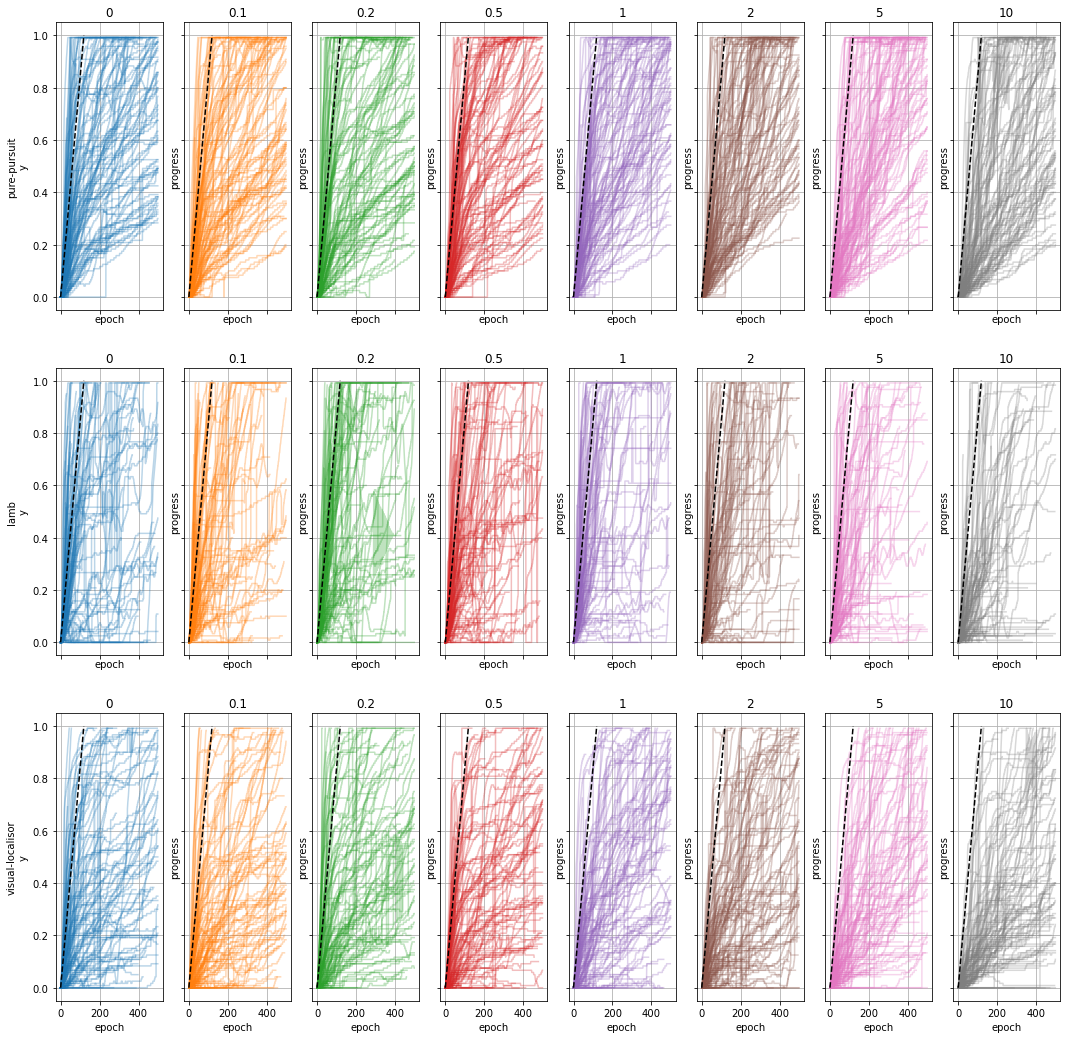

In [10]:
fig, axes = plt.subplots(3, n_condition, sharex=True, sharey=True, figsize=(18, 18))
for model_name, axrow in zip(ls_model, axes):
    for dtt, dtp_train, dtp_test, val, ax, color in zip(data_time_mindist_test2goal[model_name],
                                                        data_path_train[model_name], 
                                                        data_path_test[model_name], 
                                                        ls_value, axrow, ls_color):
        for trial_idx, (time_mindist_test2goal, path_train, path_test) in enumerate(zip(dtt, dtp_train, dtp_test)):
            if trial_idx % 1 == 0:
                test2train = pairwise_distances(path_test.T[:time_mindist_test2goal + 1], path_train.T)
                progress = np.argmin(test2train, axis=0) / n_epoch_train
                ax.plot(progress, c=color, alpha=0.3)

        ax.plot([0, n_epoch_train - 1], [0, 1], c='k', ls='dashed')
        ax.set_xlabel('epoch')
        ax.set_ylabel('progress') 
        ax.set_title(val)
        ax.grid()
        
    axrow[0].set_ylabel('{}\ny'.format(model_name))

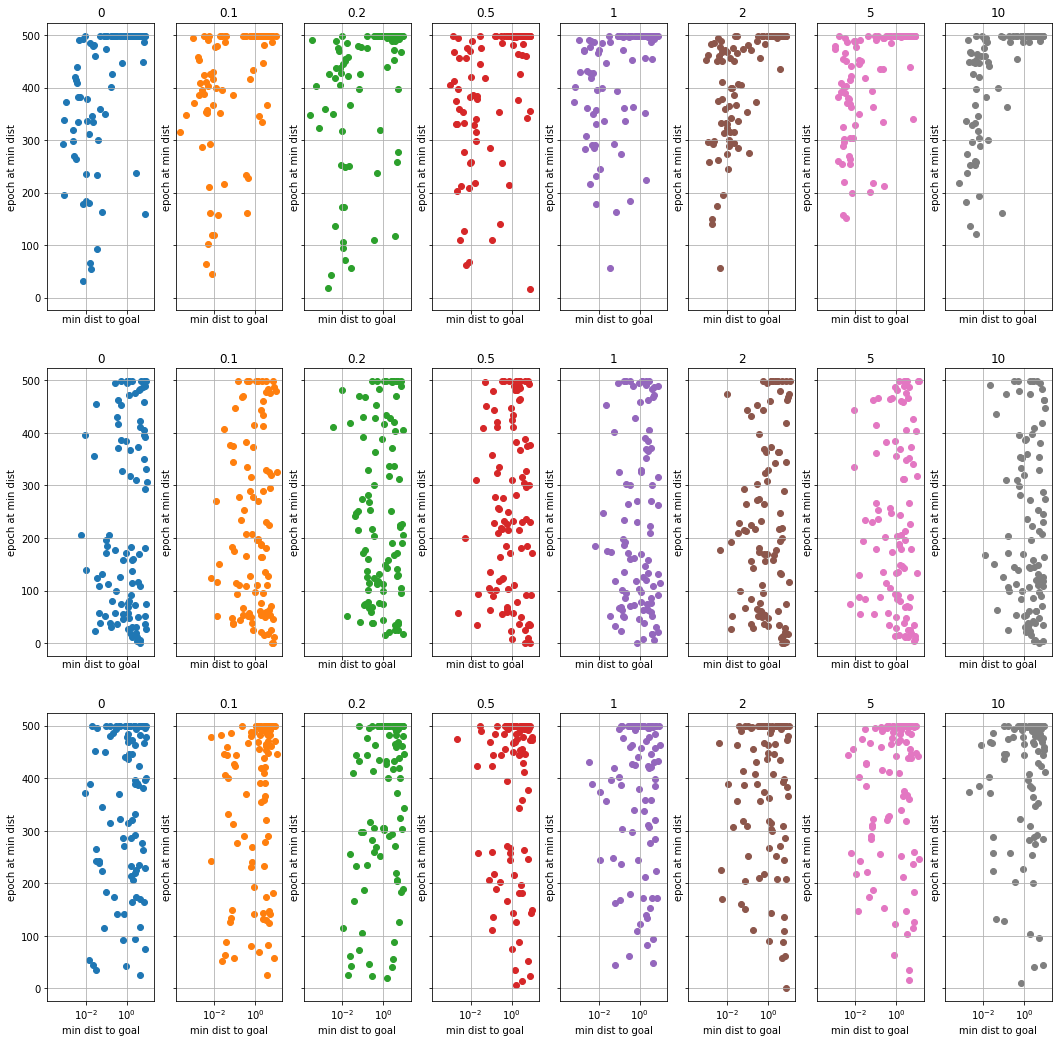

In [11]:
fig, axes = plt.subplots(3, n_condition, sharex=True, sharey=True, figsize=(18, 18))
for model_name, axrow in zip(ls_model, axes):
    for dtt, dtmd, val, ax, color in zip(data_time_mindist_test2goal[model_name], 
                                         data_mindist_test2goal[model_name], 
                                         ls_value, axrow, ls_color):
        ax.scatter(dtmd, dtt, color=color)

        ax.set_xlabel('min dist to goal')
        ax.set_ylabel('epoch at min dist')
        ax.set_xscale('log')
        ax.set_title(val)
        ax.grid()

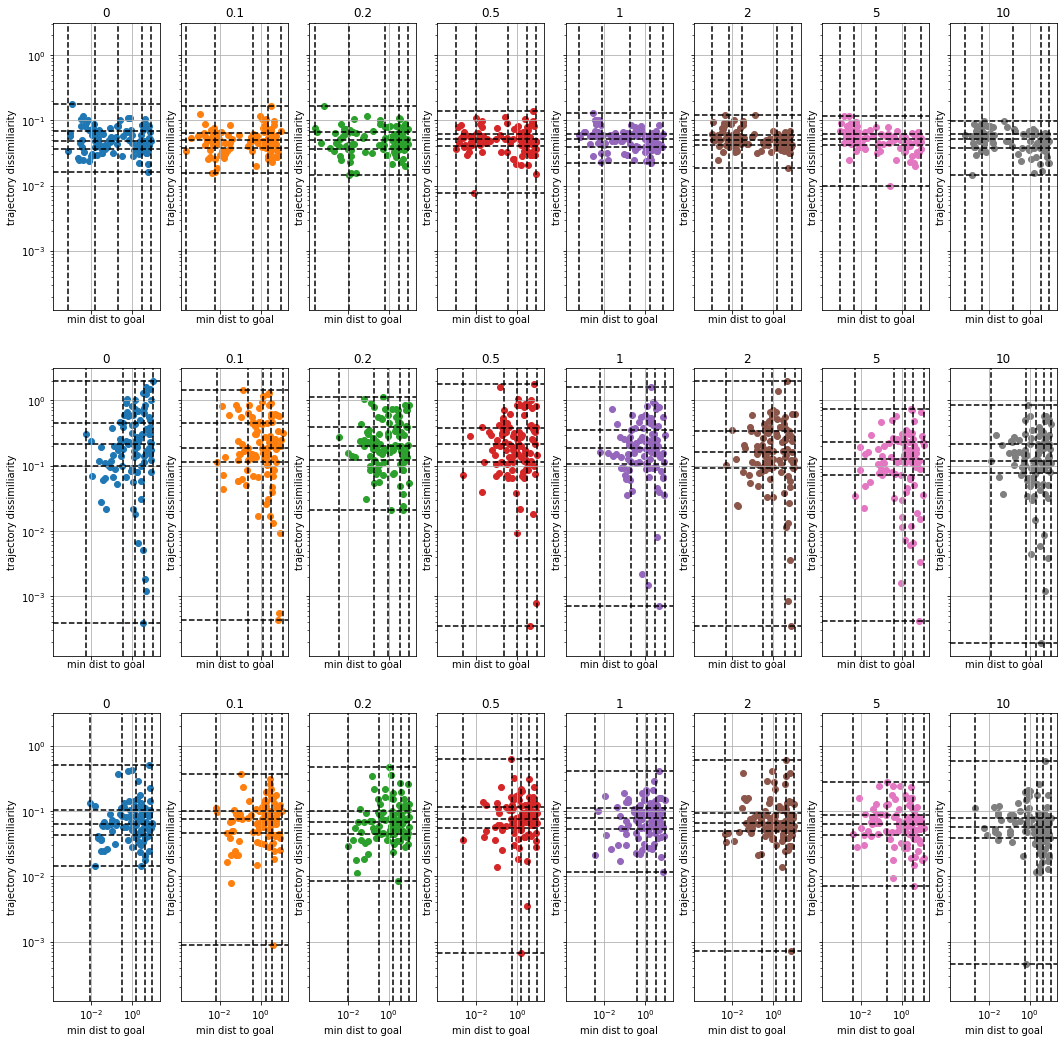

In [12]:
fig, axes = plt.subplots(3, n_condition, sharex=True, sharey=True, figsize=(18, 18))

quantile_mindist_test2goal, quantile_dsim_test2train = {}, {}
for model_name, axrow in zip(ls_model, axes):
    quantile_mindist_test2goal[model_name], quantile_dsim_test2train[model_name] = [], []
    for dsim, dtmd, val, ax, color in zip(data_dsim_test2train[model_name], 
                                          data_mindist_test2goal[model_name], 
                                          ls_value, axrow, ls_color):
        quantile_mindist_test2goal[model_name].append(np.nanquantile(dtmd, [0, 0.25, 0.5, 0.75, 1]))
        quantile_dsim_test2train[model_name].append(np.nanquantile(dsim, [0, 0.25, 0.5, 0.75, 1]))

        [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_mindist_test2goal[model_name][-1]]    
        [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_dsim_test2train[model_name][-1]]
        ax.scatter(dtmd, dsim, color=color)

        ax.set_xlabel('min dist to goal')
        ax.set_ylabel('trajectory dissimiliarity')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(val)
        ax.grid()

fig, axes = plt.subplots(3, n_condition, sharex=True, sharey=True, figsize=(18, 18))

quantile_norm_mindist_test2goal, quantile_norm_dsim_test2train = {}, {}
for model_name, axrow in zip(ls_model, axes):
    quantile_norm_mindist_test2goal[model_name], quantile_norm_dsim_test2train[model_name] = [], []
    for dti, dsim, dtmd, val, ax, color in zip(data_dist_init2goal[model_name], 
                                               data_dsim_test2train[model_name], 
                                               data_mindist_test2goal[model_name], 
                                               ls_value, axrow, ls_color):
        norm_dtmd, norm_dsim = np.divide(dtmd, dti), np.divide(dsim, dti)
        quantile_norm_mindist_test2goal[model_name].append(np.nanquantile(norm_dtmd, [0, 0.25, 0.5, 0.75, 1]))
        quantile_norm_dsim_test2train[model_name].append(np.quantile(norm_dsim, [0, 0.25, 0.5, 0.75, 1]))

        [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_norm_mindist_test2goal[model_name][-1]]    
        [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_norm_dsim_test2train[model_name][-1]]
        ax.scatter(norm_dtmd, norm_dsim, color=color)

        ax.set_xlabel('normalised min dist to goal')
        ax.set_ylabel('normalised trajectory dissimiliarity')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(val)
        ax.grid()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for ax, q in zip(axes.flatten(),
                 (quantile_dsim_test2train, quantile_mindist_test2goal, 
                  quantile_norm_dsim_test2train, quantile_norm_mindist_test2goal)):
    for model_name, color in zip(('pure-pursuit', 'differential-MB', 'visual-localisor'), ls_color):
        key = 'lamb' if model_name == 'differential-MB' else model_name
        y = np.array(q[key])
        ax.plot(np.arange(n_condition), y.T[2], marker='o', color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), y.T[1], y.T[3], color=color, alpha=0.5)
    
#     ax.set_yscale('log')
    ax.set_xticks(np.arange(n_condition), labels=ls_value)
    ax.grid()
    ax.legend()
    
for axrow in axes:
    for ax, title in zip(axrow, ('trajectory dissimilaritiy', 'minimal distance to goal')):
        ax.set_title(title)
    
for axcol in axes.T:
    for ax, ylabel in zip(axcol, ('error', 'normalised error')):
        ax.set_ylabel(ylabel)
    
for ax in axes.T[1]:
    ax.set_yscale('log')

note1: performance of lamb is good enough
    
note2: for what kind of training trajectories is lamb better/worse?
- charateristics of trajectory: straightness, length
- obstacles?

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'time of entering catchment')

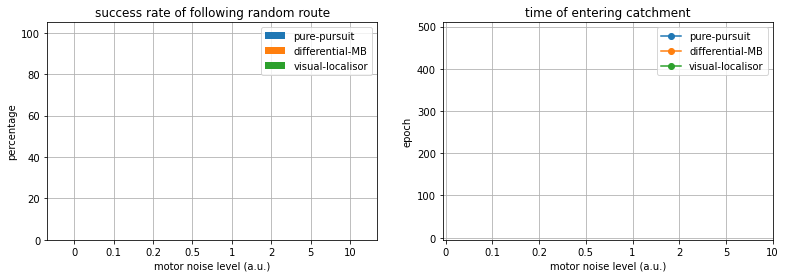

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

for (model_name, color, offset) in zip(('pure-pursuit', 'differential-MB', 'visual-localisor'), ls_color, (-0.2, 0, 0.2)):
    key = 'lamb' if model_name == 'differential-MB' else model_name
    axes[0].bar(np.arange(n_condition) + offset, 
                (1 - np.count_nonzero(np.isnan(data_success_time[key]), axis=1) / n_trial) * 100, 
                width = 0.2, label=model_name)
    lo, mid, hi = np.nanquantile(data_success_time[key], (0.25, 0.5, 0.75), axis=1)
    axes[1].plot(np.arange(n_condition), mid, marker='o', label=model_name)
    axes[1].fill_between(np.arange(n_condition), lo, hi, alpha=0.5)

    
axes[0].set_ylim(0, 105)
axes[1].set_ylim(-5, 510)
    
for ax in axes:
    ax.set_xticks(np.arange(n_condition), ls_value)
    ax.legend()
    ax.grid()
    ax.set_xlabel('motor noise level (a.u.)')
    

axes[0].set_ylabel('percentage')
axes[1].set_ylabel('epoch')
    
axes[0].set_title('success rate of following random route')
axes[1].set_title('time of entering catchment')

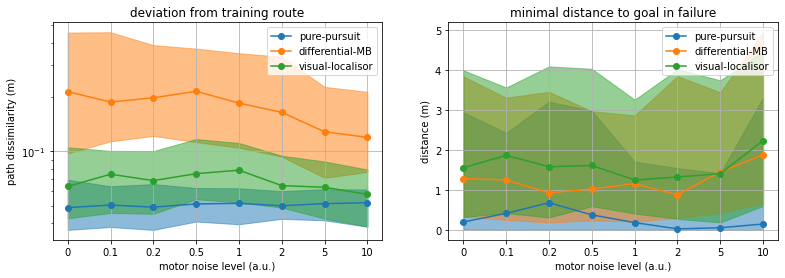

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

for ax, q in zip(axes, (quantile_dsim_test2train, quantile_mindist_test2goal)):
    for model_name, color in zip(('pure-pursuit', 'differential-MB', 'visual-localisor'), ls_color):
        key = 'lamb' if model_name == 'differential-MB' else model_name
        y = np.array(q[key])
        ax.plot(np.arange(n_condition), y.T[2], marker='o', color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), y.T[1], y.T[3], color=color, alpha=0.5)
    
#     ax.set_yscale('log')
    ax.set_xticks(np.arange(n_condition), labels=ls_value)
    ax.grid()
    ax.legend()
    
for ax, title in zip(axes, ('deviation from training route', 'minimal distance to goal in failure')):
    ax.set_title(title)
    ax.set_xlabel('motor noise level (a.u.)')
    

axes[0].set_ylabel('path dissimilarity (m)')
axes[1].set_ylabel('distance (m)')
    
axes[0].set_yscale('log')